# Image classification using CNN

## Load the data

In [1]:
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from os.path import join
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def loadCifarData(basePath):
    
    trainX = []
    testX = []
    trainY = []
    testY = []
    
    """Load training data"""
    for i in range(1, 6):
        with open(join(basePath, "data_batch_%d" %i), "rb") as f:
            dictionary = pickle.load(f, encoding = 'bytes')
            trainX.extend(dictionary[b'data'])
            trainY.extend(dictionary[b'labels'])
        
    with open(join(basePath, "test_batch"), "rb") as f:
        dictionary = pickle.load(f, encoding = 'bytes')
        testX.extend(dictionary[b'data'])
        testY.extend(dictionary[b'labels'])
            
    return trainX, trainY, testX, testY

def toImage(array, rows = 32, columns = 32):
    return array.reshape(3, rows, columns).transpose([1, 2, 0])

def toData(img, rows = 32, columns = 32):
    return img.transpose([-1, -2, 0]).flatten()

def plotImages(rows, columns, data, convert = True):
    fig, ax = plt.subplots(nrows=rows, ncols=columns)
    
    if rows == 1:
        ax = [ax]
    if columns == 1:
        ax = [ax]
        
    index = 0
    for row in ax:
        for col in row:
            if convert:
                col.imshow(toImage(data[index]))
            else:
                col.imshow(data[index])
            index = index + 1

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
trainRawX, trainRawY, testX, testY = loadCifarData("Data")

In [3]:
encoder = OneHotEncoder()
trainRawY = encoder.fit_transform(np.array(trainRawY).reshape(-1,1)).todense()

In [4]:
testY = encoder.transform(np.array(testY).reshape(-1,1)).todense()

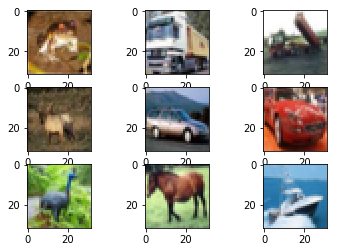

In [5]:
plotImages(3, 3, trainRawX)

## Data Augmentation

### Flip images

In [6]:
import numpy as np

def flipImage(srcImage):
    flippedImages = []
    flippedImages.append(np.fliplr(srcImage))
    #flippedImages.append(np.flipud(srcImage))
    #flippedImages.append(np.flipud(np.fliplr(srcImage)))
    return flippedImages

In [7]:
flipped = flipImage(toImage(trainRawX[1]))

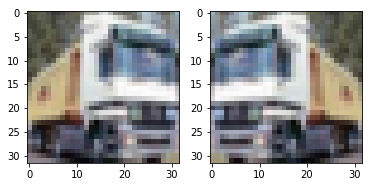

In [8]:
flipped.append(toImage(trainRawX[1]))
plotImages(1, 2, flipped, False)

### Change Brightness

In [9]:
import cv2

def changeBrightness(image):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image = np.array(image, dtype = np.float64)
    randomBrightness = .5+np.random.uniform()
    image[:,:,2] = image[:,:,2]*randomBrightness
    image[:,:,2][image[:,:,2]>255]  = 255
    image = np.array(image, dtype = np.uint8)
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image

In [10]:
noisyImage = changeBrightness(toImage(trainRawX[1]))

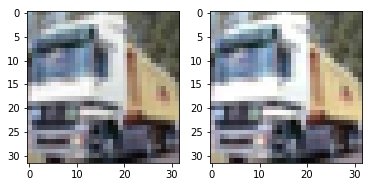

In [11]:
plotImages(1, 2, [toImage(trainRawX[1]), noisyImage], False)

### Augment Image

In [12]:
def augmentImage(imageVector):
    augmentedImages = []
    rawImages = []
    
    image = toImage(imageVector)
    flippedImages = flipImage(image)
    flippedImages.append(image)
    
    coinTossOutcome = np.random.binomial(1, 0.5, len(flippedImages))
    for img, toss in zip(flippedImages, coinTossOutcome):
        if toss == 1:
            img = changeBrightness(img)
        augmentedImages.append(img)
        rawImages.append(toData(img))
    return augmentedImages, rawImages

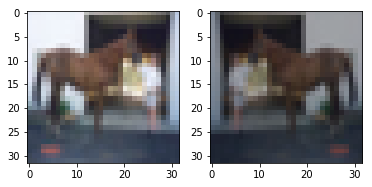

In [13]:
img, imgRaw = augmentImage(trainRawX[211])
plotImages(1, 2, img, False)

## Batch Data Iterator

In [14]:
from random import shuffle

def batchIterator(x, y, batchSize, batchCount):
    size = len(x)
    if batchSize * batchCount > size:
        raise ValueError("Change batch size or change batch count")
    
    indices = list(range(0, size))
    shuffle(indices)
    indices = indices[0:batchSize * batchCount]
    batches = np.array_split(indices, batchCount)
    for batch in batches:
        yield (x[batch], y[batch])

## Prepare data for training

In [15]:
trainX = []
trainY = []

for x, y in zip(trainRawX, trainRawY):
    rawAugmentedImages = augmentImage(x)[0]
    trainX.extend(rawAugmentedImages)
    target = [y for i in range(0, len(rawAugmentedImages))]
    trainY.extend(target)

In [16]:
print(len(trainRawX))
print(len(trainX))

50000
100000


In [17]:
print(trainRawY.shape)
print(len(trainY))

(50000, 10)
100000


In [18]:
trainX = np.stack(trainX, axis=0)
trainY = np.stack(trainY, axis=0)

In [19]:
processedTestX = []
processedTestY = []

for x, y in zip(testX, testY):
    processedTestY.append(y)
    processedTestX.append(toImage(x)) 

processedTestX = np.stack(processedTestX, axis=0)
processedTestY = np.stack(processedTestY, axis=0)

### Helper methods

In [20]:
def createConvolutionLayer(inputLayer, kernelHeight, kernelWidth, kernelCount, strideX, strideY, name):
    """This will create a four dimensional tensor
    In this tensor the first and second dimension define the kernel height and width
    The third dimension define the channel size. If the input layer is 
    first layer in neural network then the channel size will be 3 in case of RGB images
    else 1 if images are grey scale. Furthermore if the input layer is Convolution layer 
    then the channel size should be no of kernels in previous layer"""
    
    channelSize = int(inputLayer.get_shape()[-1])
    weights = tf.Variable(tf.truncated_normal([kernelHeight, kernelWidth, channelSize, kernelCount], stddev=0.03))
    bias = tf.Variable(tf.constant(0.05, shape=[kernelCount]))
    
    """Stride is also 4 dimensional tensor
    The first and last values should be 1 as they represent the image index and 
    chanel size padding. Second and Third index represent the X and Y strides"""
    layer = tf.nn.conv2d(input = inputLayer, filter = weights, padding='SAME',
                        strides = [1, strideX, strideY, 1], name = name) + bias
    return layer

In [21]:
def flattenLayer(inputLayer, name):
    """Flatten layer. The first component is image count which is useless"""
    flattenedLayer = tf.reshape(inputLayer, [-1, inputLayer.get_shape()[1:].num_elements()], name=name)
    return flattenedLayer

In [22]:
def fullyConnectedLayer(inputLayer, outputLayerCount):
    weights = tf.Variable(tf.truncated_normal(
                        [int(inputLayer.get_shape()[1]), outputLayerCount], stddev=0.03))
    bias = tf.Variable(tf.constant(0.05, shape=[outputLayerCount]))
    layer = tf.matmul(inputLayer, weights) + bias
    return layer

In [23]:
def batchNormalization(inputLayer, isTraining, name):
    beta = tf.Variable(tf.constant(0.0, shape=[inputLayer.get_shape()[-1]]), trainable=True)
    gamma = tf.Variable(tf.constant(1.0, shape=[inputLayer.get_shape()[-1]]), name='gamma', trainable=True)
    batchMean, batchVariance = tf.nn.moments(inputLayer, [0,1,2], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)

    def meanVarianceUpdate():
        emaOp = ema.apply([batchMean, batchVariance])
        with tf.control_dependencies([emaOp]):
            return tf.identity(batchMean), tf.identity(batchVariance)

    mean, var = tf.cond(isTraining, meanVarianceUpdate, lambda: (ema.average(batchMean), ema.average(batchVariance)))
    normed = tf.nn.batch_normalization(inputLayer, mean, var, beta, gamma, 1e-3, name=name)
    return normed

In [24]:
def log_histogram(writer, tag, values, step, bins=50):
    # Convert to a numpy array
    values = np.array(values)

    # Create histogram using numpy
    counts, bin_edges = np.histogram(values, bins=bins)

    # Fill fields of histogram proto
    hist = tf.HistogramProto()
    hist.min = float(np.min(values))
    hist.max = float(np.max(values))
    hist.num = int(np.prod(values.shape))
    hist.sum = float(np.sum(values))
    hist.sum_squares = float(np.sum(values**2))

    # Requires equal number as bins, where the first goes from -DBL_MAX to bin_edges[1]
    # See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/framework/summary.proto#L30
    # Thus, we drop the start of the first bin
    bin_edges = bin_edges[1:]

    # Add bin edges and counts
    for edge in bin_edges:
        hist.bucket_limit.append(edge)
    for c in counts:
        hist.bucket.append(c)

    # Create and write Summary
    summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
    writer.add_summary(summary, step)
    writer.flush()

### Define model

In [25]:
"""Input is 4 dimensional tensor -1 so that the no of images can be infered on itself"""
inputLayer = tf.placeholder(tf.float32, [None, 32, 32, 3], name="inputLayer")
yTrue = tf.placeholder(tf.float32, shape=[None, 10], name="yTrue")
isTraining = tf.placeholder(tf.bool, [])
probability = tf.placeholder(tf.float32)

convolutionLayer1 = createConvolutionLayer(inputLayer, 2, 2, 32, 1, 1, "convolutionLayer1")
reluActivated1 = tf.nn.relu(convolutionLayer1, name = "relu1")
poolingLayer1 = tf.layers.max_pooling2d(inputs=reluActivated1, pool_size=[2, 2],
                                        strides = [1, 1], padding='SAME', name="poolingLayer1")

bn1 = batchNormalization(poolingLayer1, isTraining, "batchNormalization1")
dropout1 = tf.nn.dropout(bn1, keep_prob = probability)
convolutionLayer2 = createConvolutionLayer(dropout1, 2, 2, 20, 1, 1, "convolutionLayer2")

reluActivated2 = tf.nn.relu(convolutionLayer2, name = "relu2")
poolingLayer2 = tf.layers.max_pooling2d(inputs=reluActivated2, pool_size=[2, 2],
                                        strides = [2, 2], padding='SAME', name="poolingLayer2")
bn2 = batchNormalization(poolingLayer2, isTraining, "batchNormalization2")
dropout2 = tf.nn.dropout(bn2, keep_prob = probability)
flattened = flattenLayer(dropout2, name = "flattenedLayer")
fc1 = fullyConnectedLayer(flattened, 1000)
reluActivated3 = tf.nn.relu(fc1, name = "relu3")
fc2 = fullyConnectedLayer(reluActivated3, 500)
reluActivated4 = tf.nn.relu(fc2, name = "relu4")
output = fullyConnectedLayer(reluActivated4, 10)

### Define Predictions

In [26]:
predictions = tf.argmax(tf.nn.softmax(output), axis = 1)
actual = tf.argmax(yTrue, axis = 1)

### Define loss function and specify the optimizer

In [27]:
loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels = yTrue)

In [28]:
costFunction = tf.reduce_mean(loss)
optimizer = tf.train.GradientDescentOptimizer(1e-2).minimize(costFunction)

In [29]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, actual), tf.float32))

### Create session and initialize global variables

In [30]:
session = tf.Session()
"""Initialize the global variables"""
session.run(tf.global_variables_initializer())

In [31]:
summaryWriter =  tf.summary.FileWriter("tensorboard/structure5/logs", graph=tf.get_default_graph())
trainAccList = []
testAccList = []
for i in range(0, 20):
    print("Epoch "+str(i))
    summary = tf.Summary()
    
    for x, y in batchIterator(trainX, trainY, 500, 100):
        session.run(optimizer, feed_dict={inputLayer:x, yTrue:y, isTraining:True, probability:0.6})
    
    loss = session.run(costFunction, feed_dict={inputLayer:x, yTrue:y, isTraining:False, probability:1})
    acc = session.run(accuracy, feed_dict={inputLayer:x, yTrue:y, isTraining:False, probability:1})    
    summary.value.add(tag = "TrainingLoss", simple_value = loss)
    summary.value.add(tag = "TrainingAcc", simple_value = acc)
    trainAccList.append(acc)
        
    lossTestList = []
    accTestList = []
    for x, y in batchIterator(processedTestX, processedTestY, 1000, 5):
        lossTest = session.run(costFunction, feed_dict={inputLayer:x, yTrue:y, isTraining:False, probability:1})
        accTest = session.run(accuracy, feed_dict={inputLayer:x, yTrue:y, isTraining:False, probability:1})
        lossTestList.append(lossTest)
        accTestList.append(accTest)
    print(np.mean(accTestList))
    summary.value.add(tag = "TestLoss", simple_value = np.mean(lossTestList))
    summary.value.add(tag = "TestAcc", simple_value = np.mean(accTestList))
    testAccList.append(np.mean(accTestList))
    summaryWriter.add_summary(summary, i)

Epoch 0
0.3066
Epoch 1
0.361
Epoch 2
0.4092
Epoch 3
0.349
Epoch 4
0.34759998
Epoch 5
0.49179998
Epoch 6
0.48540002
Epoch 7
0.37860003
Epoch 8
0.5118
Epoch 9
0.52699995
Epoch 10
0.5406
Epoch 11
0.3396
Epoch 12
0.5562
Epoch 13
0.3946
Epoch 14
0.43660003
Epoch 15
0.55499995
Epoch 16
0.5672
Epoch 17
0.489
Epoch 18
0.517
Epoch 19
0.59540004


In [32]:
log_histogram(summaryWriter, "TrainAccHist", trainAccList, 50)
log_histogram(summaryWriter, "TestAccHist", testAccList, 50)

In [33]:
session.close()

In [34]:
trainAccList

[0.31,
 0.366,
 0.376,
 0.34,
 0.334,
 0.516,
 0.474,
 0.424,
 0.556,
 0.5,
 0.55,
 0.388,
 0.55,
 0.406,
 0.46,
 0.55,
 0.588,
 0.532,
 0.564,
 0.622]

In [35]:
testAccList

[0.3066,
 0.361,
 0.4092,
 0.349,
 0.34759998,
 0.49179998,
 0.48540002,
 0.37860003,
 0.5118,
 0.52699995,
 0.5406,
 0.3396,
 0.5562,
 0.3946,
 0.43660003,
 0.55499995,
 0.5672,
 0.489,
 0.517,
 0.59540004]